Case study 1: Capillary rise
===

#### The first few cells in this notebook define the imports, physical and numerical parameters used in the case study. The parameters can be modified by the user to produce new results.

In [16]:
## Imports and physical parameters
# std library
import numpy as np
import scipy

# plotting
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

# ddg imports
# Allow for relative imports from main library:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from ddgclib import *
from ddgclib._case1 import *
from ddgclib._complex import *
from ddgclib._curvatures import * #plot_surface#, curvature
from ddgclib._capillary_rise_flow import * #plot_surface#, curvature
from ddgclib._capillary_rise import * #plot_surface#, curvature
from ddgclib._eos import *
from ddgclib._misc import *
from ddgclib._plotting import *

# Parameters for a water droplet in air at standard laboratory conditions
gamma = 0.0728  # N/m, surface tension of water at 20 deg C
rho = 1000  # kg/m3, density
g = 9.81  # m/s2

# Parameters from EoS:
T_0 = 273.15 + 25  # K, initial tmeperature
P_0 = 101.325  # kPa, ambient pressure
#gamma = IAPWS(T_0)  # N/m, surface tension of water at 20 deg C
gamma = 0.0728  # N/m, surface tension of water at 20 deg C
#rho_0 = eos(P=P_0, T=T_0)  # kg/m3, densi
rho = 1000  # kg/m3, density
g = 9.81  # m/s2

# Capillary rise parameters
r = 2.0e-6  # m, radius of the tube
theta_p = 20 * np.pi/180.0  # Three phase contact angle
r = np.array(r, dtype=np.longdouble)
theta_p = np.array(theta_p, dtype=np.longdouble)


# Numerical parameters
N = 7  # Number of boundary points = N - 1
refinement = 0  # Number of refinements to the simplicial complex
cdist = 1e-10

#### The current system can be visualized at any time with the `cape_rise_plot` function:

In [17]:
fig, axes, HC = cape_rise_plot(r, theta_p, gamma, N=N,
                               refinement=refinement)


<Figure size 640x480 with 0 Axes>

### Basic data structures:

The object containing the interface simplicial complex is called `HC` which is an instance of a `Complex` object. Each simplicial complex contains an attribute `V` which is the case of vertices that can be accessed using `HC.V`


In [18]:
HC.V

For example, we can build a newly initiated complex using the vectorized outputs `F` and `nn` from `cap_rise_init_N`. And then using `construct_HC` we can build a new complex object `HC`, where `F` is an array of points in 3-dimensional space and `nn` is an index of neighbouring edges. 

In [19]:
F, nn, HC, bV, K_f, H_f = cap_rise_init_N(r, theta_p, gamma, N=N, refinement=refinement)
HC = construct_HC(F, nn)
F, nn

(array([[ 0.00000000e+00,  0.00000000e+00, -1.40041508e-06],
        [ 0.00000000e+00,  2.00000000e-06,  0.00000000e+00],
        [ 1.73205081e-06,  1.00000000e-06,  0.00000000e+00],
        [ 1.73205081e-06, -1.00000000e-06,  0.00000000e+00],
        [ 0.00000000e+00, -2.00000000e-06,  0.00000000e+00],
        [-1.73205081e-06, -1.00000000e-06,  0.00000000e+00],
        [-1.73205081e-06,  1.00000000e-06,  0.00000000e+00],
        [ 0.00000000e+00,  2.00000000e-06,  0.00000000e+00]], dtype=float64),
 [[1, 2, 3, 4, 5, 6, 7],
  [0, 7, 2],
  [0, 1, 3],
  [0, 2, 4],
  [0, 3, 5],
  [0, 4, 6],
  [0, 5, 0],
  [0, 6, 1]])

In [20]:
HC = Complex(3)
HC.V.print_out()

Vertex cache of size: 0:


In [21]:
V = []
for f in F:
    print(f)
    V.append(HC.V[tuple(f)])

[ 0.00000000e+00  0.00000000e+00 -1.40041508e-06]
[0.e+00 2.e-06 0.e+00]
[1.73205081e-06 1.00000000e-06 0.00000000e+00]
[ 1.73205081e-06 -1.00000000e-06  0.00000000e+00]
[ 0.e+00 -2.e-06  0.e+00]
[-1.73205081e-06 -1.00000000e-06  0.00000000e+00]
[-1.73205081e-06  1.00000000e-06  0.00000000e+00]
[0.e+00 2.e-06 0.e+00]


In [22]:
HC.V.print_out()

Vertex cache of size: 7:
Vertex: (0.0, 0.0, -1.4004150764194194e-06)
Connections: 
Vertex: (0.0, 2e-06, 0.0)
Connections: 
Vertex: (1.7320508075688771e-06, 1.0000000000000002e-06, 0.0)
Connections: 
Vertex: (1.7320508075688774e-06, -9.999999999999995e-07, 0.0)
Connections: 
Vertex: (0.0, -2e-06, 0.0)
Connections: 
Vertex: (-1.732050807568877e-06, -1.0000000000000008e-06, 0.0)
Connections: 
Vertex: (-1.732050807568878e-06, 9.999999999999987e-07, 0.0)
Connections: 


In [23]:
for i, i_nn in enumerate(nn):
    print(i_nn)
    for i_v2 in i_nn:
        V[i].connect(V[i_v2])

[1, 2, 3, 4, 5, 6, 7]
[0, 7, 2]
[0, 1, 3]
[0, 2, 4]
[0, 3, 5]
[0, 4, 6]
[0, 5, 0]
[0, 6, 1]


In [24]:
HC = Complex(3)
V = []
for f in F:
    V.append(HC.V[tuple(f)])
for i, i_nn in enumerate(nn):
    for i_v2 in i_nn:
        V[i].connect(V[i_v2])

In [25]:
Complex

ddgclib._complex.Complex

In [26]:
F, nn, HC, bV, K_f, H_f = cap_rise_init_N(r, theta_p, gamma, N=N, refinement=refinement)


In [27]:
plot_polyscope(HC)

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
self.V[v].index = 0
self.V[v].index = 1
self.V[v].index = 2
self.V[v].index = 3
self.V[v].index = 4
self.V[v].index = 5
self.V[v].index = 6


Vertices contained in the current cache can be converted to vector format using the `b_vectorise_vnn` function. For example looping over all the current vertices:

In [28]:
for v in HC.V:
    F, nn = vectorise_vnn(v)

The main function that we use to compute curvature tensors is called `b_curvatures_hn_ij_c_ij`. In principle any custom routine can be built by looping over all vertices and accessing the `b_curvatures_hn_ij_c_ij`function:

In [29]:
# First find the vectorised format of the last vertex from the previous loop
F, nn = vectorise_vnn(v)
curvature_dict = b_curvatures_hn_ij_c_ij(F, nn)
print(curvature_dict)

{'F': array([[-1.73205081e-06,  1.00000000e-06,  0.00000000e+00],
       [ 0.00000000e+00,  2.00000000e-06,  0.00000000e+00],
       [-1.73205081e-06, -1.00000000e-06,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -1.40041508e-06]], dtype=float64), 'nn': [[1, 2, 3], [3], [3], [1, 2]], 'n_i': array([-0.8660254,  0.5      ,  0.       ], dtype=float64), 'E_ij': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.73205081e-06,  1.00000000e-06,  0.00000000e+00],
       [ 6.35274710e-22, -2.00000000e-06,  0.00000000e+00],
       [ 1.73205081e-06, -1.00000000e-06, -1.40041508e-06]], dtype=float64), 'E_jk': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -2.00000000e-06, -1.40041508e-06],
       [-1.73205081e-06, -1.00000000e-06,  1.40041508e-06],
       [-1.73205081e-06, -1.00000000e-06,  1.40041508e-06]], dtype=float64), 'E_ik': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.73205081e-06, -1.0000000

In [30]:
curvature_dict['NdA_i']

array([-2.33402513e-13,  4.04265011e-13,  0.00000000e+00], dtype=float64)

Next we plot the outputs of the first case study by looping over a range of three-phase contact angles `theta_p`
==

The `plot_cap_rise_over_theta` function was developed to plot different curvatures over the full range:

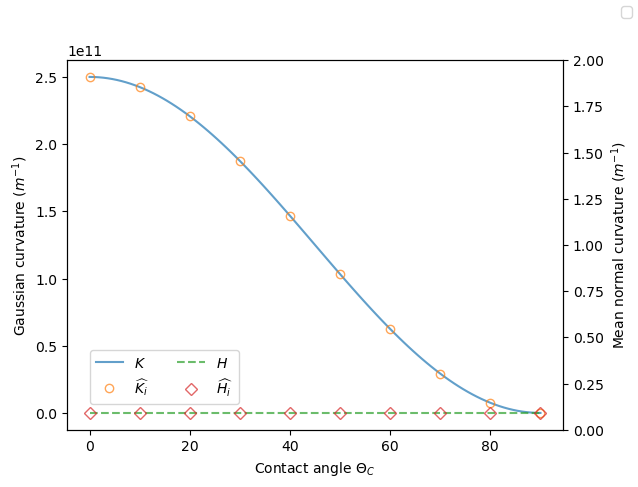

In [6]:
plot_cap_rise_over_theta(r, gamma, N=N, refinement=refinement)


Plotting geometric and surface tension errors
===

Next we replicate the figure in the manuscript demonstrating the errors over refinement. The `int_curvatures` function loops over all vertices and produces the `HN_i` curvature tensors at each vertex. 

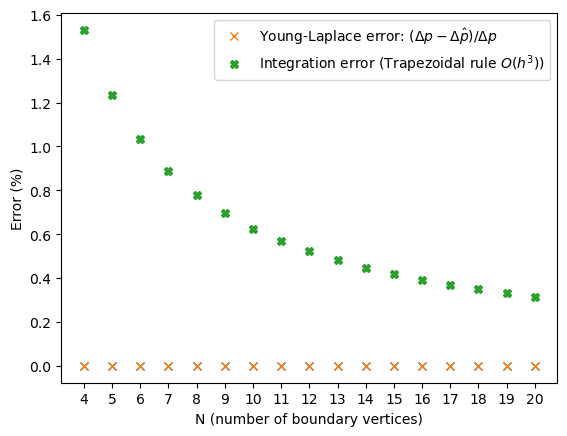

In [7]:
cdist = 1e-10

# Replot error data
Nmax = 21  # Number of boundary vertices to range over
Nlist = list((range(4, Nmax)))
erange = []
lp_error = []
refinement = 1
phi = 2
r = 1  # m, Radius of the capillary tube
theta_p = 20 * np.pi / 180.0  # Three phase contact angle
R = r / np.cos(theta_p)  # = R at theta = 0

# Loop over the range of specific boundary vertices
for N in range(5, Nmax + 1):
    F, nn, HC, bV, K_f, H_f = cap_rise_init_N(r, theta_p, gamma, N=N,
                                              refinement=refinement,
                                              cdist=cdist
                                              )

    
    (HNda_v_cache, K_H_cache, C_ijk_v_cache, HN_i,  HNdA_ij_dot_hnda_i,
     K_H_2, HNdA_i_Cij) = int_curvatures(HC, bV, r, theta_p, printout=0)
    
    # Laplacian error at each vertex (point-wise)
    P_L = gamma*(2.0/R)  # Analytical solution
    H_dis = HNdA_ij_dot_hnda_i[0]
    L_error = 100 *(P_L - gamma * H_dis)/(P_L)
    lp_error.append(abs(L_error) )
    
    # Geometric error over edges 
    max_int_e = 0.0
    ern = 0.0
    for v in bV:
        for v2 in v.nn:
            if v2 in bV:
                a = v.x_a
                b = v2.x_a
                if N == 14:
                    #print(f'numpy.linalg.norm(a - b) = {numpy.linalg.norm(a - b)}')
                    continue
                break
        ern = 2*numpy.linalg.norm(a - b)
        max_int_e = ern
        break

    erange.append(max_int_e/r)

# Computed from step size on Euclidean metric for cap rise:
geo_error = erange

plot.figure()

plt.plot(Nlist, lp_error, 'x')
plt.plot(Nlist, lp_error, 'x', label='Young-Laplace error: $(\Delta p - \Delta\hat{ p})/\Delta p $')
plt.plot(Nlist, geo_error, 'X', label='Integration error (Trapezoidal rule $O(h^3)$)')
plt.legend()
plt.xlabel(r'N (number of boundary vertices)')
plt.ylabel(r'Error (%)')


matplotlib.pyplot.xticks(Nlist)

plt.tick_params(axis='y', which='minor')

plt.show()

Note also that `HC` can be visaulized at any time. For example, we can plot the complex at the last iteration:

In [8]:
fig, axes, HC = cape_rise_plot(r, theta_p, gamma, N=N, refinement=refinement)

<Figure size 640x480 with 0 Axes>

In [9]:
plot_polyscope(HC)

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
self.V[v].index = 0
self.V[v].index = 1
self.V[v].index = 2
self.V[v].index = 3
self.V[v].index = 4
self.V[v].index = 5
self.V[v].index = 6
self.V[v].index = 7
self.V[v].index = 8
self.V[v].index = 9
self.V[v].index = 10
self.V[v].index = 11
self.V[v].index = 12
self.V[v].index = 13
self.V[v].index = 14
self.V[v].index = 15
self.V[v].index = 16
self.V[v].index = 17
self.V[v].index = 18
self.V[v].index = 19
se